# 4.5 シェーディング補正

## この節について

この節では、シェーディング補正について解説します。

この節のの内容はColabノートブックとして公開してあります。ノートブックを見るには[目次ページ](https://colab.research.google.com/github/moizumi99/camera_raw_processing/blob/master/camera_raw_toc.ipynb)から参照するか、以下のリンクを使ってアクセスしてください。

https://colab.research.google.com/github/moizumi99/camera_raw_processing/blob/master/camera_raw_chapter_4_5.ipynb

## 準備

まずライブラリーのインストールと、モジュールのインポート、画像の読み込みを行います。今回もラズベリーパイで撮影したチャート画像を使用します。
内容については各節を参照ください。

In [1]:
# rawpyとimageioのインストール
!pip install rawpy;
!pip install imageio;

# rawpy, imageio, numpuy, pyplot, imshowのインポート
import rawpy, imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# 前節までに作成したモジュールのダウンロードとインポート
!if [ ! -f raw_process.py ]; then wget https://github.com/moizumi99/camera_raw_processing/raw/master/raw_process.py; fi
from raw_process import simple_demosaic, white_balance, black_level_correction, gamma_correction, demosaic, defect_correction, color_correction_matrix

# 日本語フォントの設定
!apt -y install fonts-ipafont-gothic
plt.rcParams['font.family'] = 'IPAPGothic'
# もし日本語が文字化けしている場合`! rm /content/.cache/matplotlib/fontList.json`を実行して、
# Runtime->Restart Runtimeで再実行

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


## レンズシェーディング（周辺減光）とは

デジタルカメラに限らず、レンズを通して結像した画像は中央部より周辺部のほうが暗くなっています。

このような現象をレンズシェーディングや単にシェーディング、また日本語では周辺減光などといいます。英語ではLens ShadingやVignettingと呼ばれます。

このような事が起きてしまう第一の原因は、レンズを通してセンサーにあたる光の量が、センサーの中央部と、センサーの周辺部とで異なる事です。
良く説明に出されるのが二枚のレンズを持つ単純な系の場合です。

![レンズシェーディングが起こるしくみ](https://github.com/moizumi99/camera_raw_processing/raw/master/fig_4_5_1.png)

この図の例では、センサー中央部分にあたる光はレンズの開口部全体を通ってくるのに対して、センサー周辺部にあたる光はレンズの一部分しか通過できません。
結果的に中心部が明るく、周辺部が暗くなります。
実際のカメラの光学系はこれより遥かに複雑ですが、同様の理由により画像の周辺部分が暗くなります。

この要因の他に、センサー周辺部ではレンズやカバーの縁に遮られる光の量も増えます。また、光の入射角度によってレンズ等のコーティングと干渉する可能性もあります。
またデジタルカメラ独特の状況として、画像センサー上のフォトダイオードに到達する光の量が、光の入射角に依存するケースがあります。

シェーディングを起こす要因はこのように多岐にわたり、一概に、これが原因だとは言うことはできません。
したがってモデル計算で減光量を求めるよりも、実際のレンズで測定した結果を元に画像補正する必要があります。

## レンズシェーディングの確認

では実際にシェーディングの影響を見てみましょう。

本来ならば明るさを均一にしたグレイチャート（その名の通り灰色の大きなシート）などを撮影してテストするのですが普通の家庭にそのような物はないので、今回はラズベリーパイのレンズの上に白いコピー用紙を載せ、そこに後ろから光を当てることでなるべく一様な明るさの画像を撮影しました。ファイル名は ```flat.jpg```です。このファイルは[githubにアップロードしてあります](https://github.com/moizumi99/camera_raw_processing/raw/master/flat.jpg)。

まずはダウンロードしてみます。

In [2]:
! wget https://github.com/moizumi99/camera_raw_processing/raw/master/flat.jpg

--2019-02-02 15:43:54--  https://github.com/moizumi99/camera_raw_processing/raw/master/flat.jpg
Resolving github.com (github.com)... 192.30.255.113, 192.30.255.112
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/moizumi99/camera_raw_processing/master/flat.jpg [following]
--2019-02-02 15:43:54--  https://raw.githubusercontent.com/moizumi99/camera_raw_processing/master/flat.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.40.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.40.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14561271 (14M) [application/octet-stream]
Saving to: ‘flat.jpg.3’

flat.jpg.3          100%[===================>]  13.89M  46.7MB/s    in 0.3s    

2019-02-02 15:43:55 (46.7 MB/s) - ‘flat.jpg.3’ saved [14561271/14561271]



このファイルからRAW画像を取り出し現像してみましょう。
まだレンズシェーディング補正は行いません。

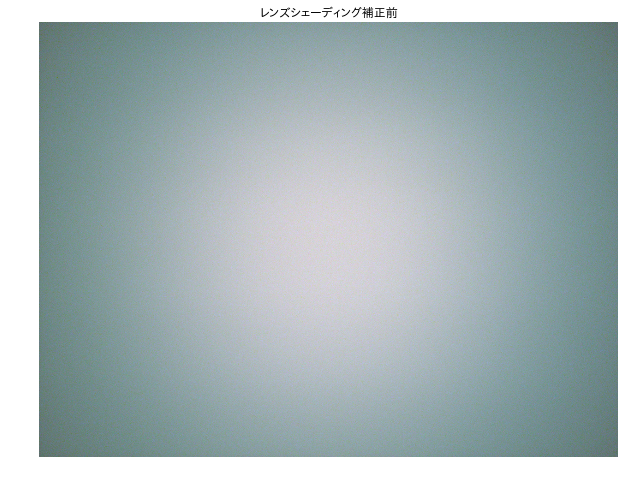

In [3]:
# RAW画像の読み込み。
raw_file  = "flat.jpg"
raw = rawpy.imread(raw_file)
raw_array = raw.raw_image
h, w = raw.sizes.raw_height, raw.sizes.raw_width
raw_array = raw_array.reshape((h, w));

#RAW現像処理
blc_raw = black_level_correction(raw_array, raw.black_level_per_channel, raw.raw_pattern)
dpc_raw = defect_correction(blc_raw, 16)
wb_raw = white_balance(dpc_raw, raw.camera_whitebalance, raw.raw_colors)
dms_img = demosaic(wb_raw, raw.raw_colors)
color_matrix = [6022,-2314,394,-936,4728,310,300,-4324,8126]
ccm_img = color_correction_matrix(dms_img, color_matrix)
no_shading_img = gamma_correction(ccm_img, 2.2)

# 画像表示
plt.figure(figsize=(16, 8))
plt.imshow(no_shading_img)
plt.axis('off')
plt.title(u"レンズシェーディング補正前")
plt.show()

確かに周辺光量が落ちているのが確認できます。その他に画像中央部と周辺部とで色味が違うのもわかると思います。

画像の中で明るさがどう変わっているか見てみましょう。
画面の高さ方向中央付近、上下３２画素幅で左から右まで帯状の画像をとりだし、明るさがどう変わるをグラフにしてみます。

In [4]:
# 基準となる画像中央部の位置
center_y, center_x = h // 2, w // 2
# 明るさの配列を保存する配列
shading_profile = [[], [], []]

# 画面中央の上下+/-16ライン幅で測定
y = center_y - 16
# 横方向３２画素毎にサンプリング
for x in range(0, w - 32, 32):
    xx = x + 16
    # (x, y)から(x+32, y+32)を対角線とする正方形内部の画素の平均
    # 色ごとに保存する。
    shading_profile[0].append(no_shading_img[y:y+32, x:x+32, 0].mean())
    shading_profile[1].append(no_shading_img[y:y+32, x:x+32, 1].mean())
    shading_profile[2].append(no_shading_img[y:y+32, x:x+32, 2].mean())
# 画像中央部の値で正規化する
shading_profile = [np.array(a) / max(a) for a in shading_profile]

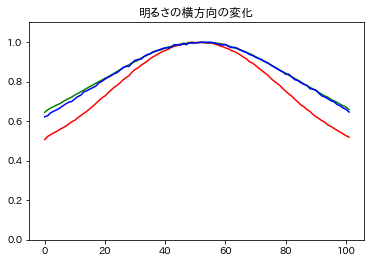

In [5]:
plt.axis(ymin=0, ymax=1.1)
plt.plot(shading_profile[0], color='red')
plt.plot(shading_profile[1], color='green')
plt.plot(shading_profile[2], color='blue')
plt.title(u"明るさの横方向の変化")
plt.show()

画像の左右端では中心部分に比べて50%程度の明るさに落ちていることがわかります。
これはガンマ補正後の値なので、RAW画像では明るさの違いはさらに大きいことが予想できます。

また、赤画素と、緑・青画素とではシェーディングの様子がだいぶ違います。画像の色が中央と周辺部でだいぶ違うのはこのせいでしょう。

## レンズシェーディングのモデル化

レンズシェーディングを補正するために、まずどの程度の減光があるのか測定してみましょう。

画像を見てわかるとおり、光の量は中心から離れるに従って減っています。中央からの距離によってパラメータ化できそうです。
また、対称性を考えると偶関数で近似できるはずです。

では各画素の明るさを、中央からの距離に応じてグラフにしてみましょう。

一画素毎に計算するのは計算量が大きくまたノイズによる誤差も入ってくるので、32 x 32のブロックごとに測定します。
また、今度は実際に補正する量の見積もりに使いたいのでBayerでの値を使います。
ゼロレベルを正しく取る必用があるので、測定する対象はブラックレベル補正後の画像です。

In [6]:
# 測定値を入れる配列を色の数分だけ準備する。
vals = [[], [], [], []]
# 中心からの距離を保存
radials = []

# 32x32のブロック毎に処理を行います。
# (x, y)から(x+32, y+32)を対角線とする正方形毎に処理。
for y in range(0, h, 32):
    for x in range(0, w - 32, 32):
        # (xx, yy)は正方形の中心。
        xx = x + 16
        yy = y + 16
        # 正方形の中心と画像の中心の間の距離を求め記録。
        r2 = (yy - center_y) * (yy - center_y) + (xx - center_x) * (xx - center_x)
        radials.append(r2)
        # 色ごとに正方形の中の画素の平均値を求める。
        vals[0].append(blc_raw[y:y+32:2, x:x+32:2].mean())
        vals[1].append(blc_raw[y:y+32:2, x+1:x+32:2].mean())
        vals[2].append(blc_raw[y+1:y+32:2, x:x+32:2].mean())
        vals[3].append(blc_raw[y+1:y+32:2, x+1:x+32:2].mean())

これで```vals[]```には色ごとの画素の明るさ、```radials```には中央からの距離の２乗が入っているはずです。

最大値でノーマライズしてグラフにして確認してみます。

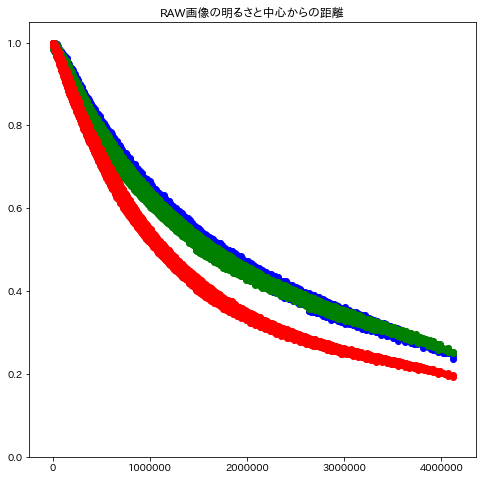

In [7]:
# 扱いやすいようにnumpyの配列に変換。
rs = np.array(radials)
vs = np.array(vals)
# 最大値で正規化
norm = vs.max(axis=1)
vs[0, :] /= vs[0, :].max()
vs[1, :] /= vs[1, :].max()
vs[2, :] /= vs[2, :].max()
vs[3, :] /= vs[3, :].max()
# Pyplotの散乱図機能でグラフを描画。
plt.figure(figsize=(8, 8))
plt.scatter(rs, vs[0,:], color='blue')
plt.scatter(rs, vs[1,:], color='green')
plt.scatter(rs, vs[2,:], color='green')
plt.scatter(rs, vs[3,:], color='red')
plt.ylim(0, 1.05)
plt.title(u"RAW画像の明るさと中心からの距離")
plt.show()

きれいに中心からの距離に応じて明るさが減少しています。
また、この段階では周辺部では中心部に比べて３分の１程度に暗くなっていることがわかります。

これを補正するには、明るさの減少率の逆数をかけてやればよい事になります。
逆数のグラフを書いてみましょう。

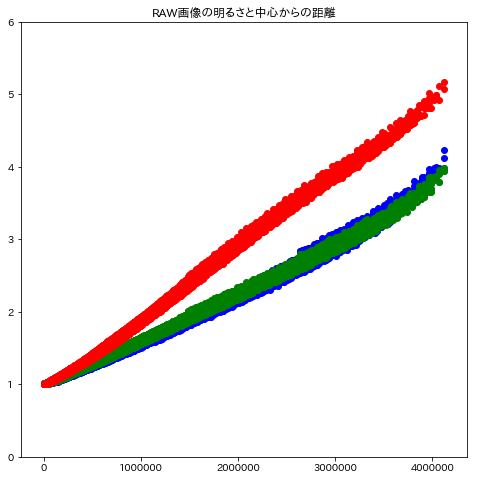

In [8]:
# 明るさの逆数を求める。
gs = 1 / vs
# 明るさの逆数のグラフ。
plt.figure(figsize=(8, 8))
plt.scatter(rs, gs[0,:], color='blue')
plt.scatter(rs, gs[1,:], color='green')
plt.scatter(rs, gs[2,:], color='green')
plt.scatter(rs, gs[3,:], color='red')
plt.title(u"RAW画像の明るさと中心からの距離")
plt.ylim(0, 6)
plt.show()

これなら１次関数で近似できそうです。
横軸は距離の二乗なので、距離の関数としては二次多項式になります。

やってみましょう。近似には、numpyの多項式近似機能polyfitを使います。使い方は、

`ps = polyfit(xs, ys, o)`

で、xsは入力、ysは出力、oは次数です。psには各次の係数が入ります。

In [9]:
# 係数をしまう配列を色の数分だけ準備。
par = [[], [], [], []]
# 各色ごとに１次式で近似。
for color in range(4):
    par[color] = np.polyfit(rs, gs[color, :], 1)

これで```par[]```には近似関数の傾きと切片が入っているはずです。
確認してみましょう。

In [10]:
print(par)

[array([6.55713373e-07, 9.35608322e-01]), array([6.53200037e-07, 9.60626646e-01]), array([6.49653241e-07, 9.63338394e-01]), array([1.00153497e-06, 9.09326661e-01])]


それらしい値が入っています。グラフにしてでみてみましょう。

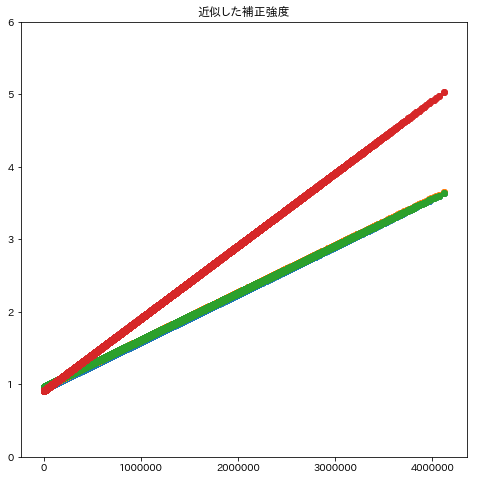

In [11]:
# 各色ごとの１次式の出力
es = [[], [], [], []]
# 各色ごとに、中心からの距離(rs)に応じた値を求める
for color in range(4):
    es[color] = par[color][0] * rs + par[color][1]
# 各色ごとにグラフ表示
plt.figure(figsize=(8, 8))
for color in range(4):
    plt.scatter(rs, es[color])
plt.ylim(0, 6)
plt.title(u"近似した補正強度")
plt.show()

良さそうです。

## レンズシェーディング補正

ではいよいよ、実際の画像のレンズシェーディングを補正してみましょう。

まず、レンズシェーディング補正前の、ブラックレベル補正のみをかけたRAW画像がこちらです。

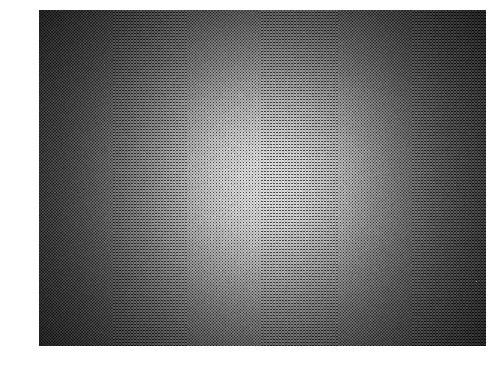

In [12]:
plt.figure(figsize=(8, 8))
plt.imshow(blc_raw, cmap='gray')
plt.axis('off')
plt.show()

先に各画素ごとに掛け合わせるゲインを、先程の近似関数から計算しておきます。

In [13]:
gain_map = np.zeros((h, w))
center_y, center_x = h // 2, w // 2
for y in range(0, h, 2):
    for x in range(0, w, 2):
        r2 = (y - center_y) **2 + (x - center_x) **2
        gain = [par[i][0] * r2 + par[i][1] for i in range(4)]
        gain_map[y, x] = gain[0]
        gain_map[y, x+1] = gain[1]
        gain_map[y+1, x] = gain[2]
        gain_map[y+1, x+1] = gain[3]

このゲインをブラックレベル補正した画像にかけ合わせます。

In [14]:
lsc_raw = blc_raw * gain_map

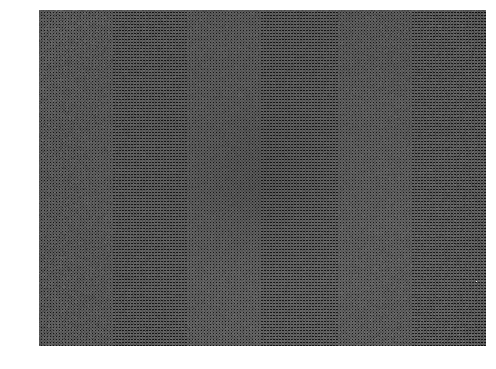

In [15]:
outimg = lsc_raw.copy()
outimg /= 1024
outimg[outimg < 0] = 0
outimg[outimg > 1] = 1
plt.figure(figsize=(8, 8))
plt.imshow(outimg, cmap='gray')
plt.axis('off')
plt.show()

フラットな画像が出力されました！

残りの処理（ホワイトバランス補正、デモザイク、カラーマトリクス補正、ガンマ補正）を行ってフルカラー画像を出力してみましょう。

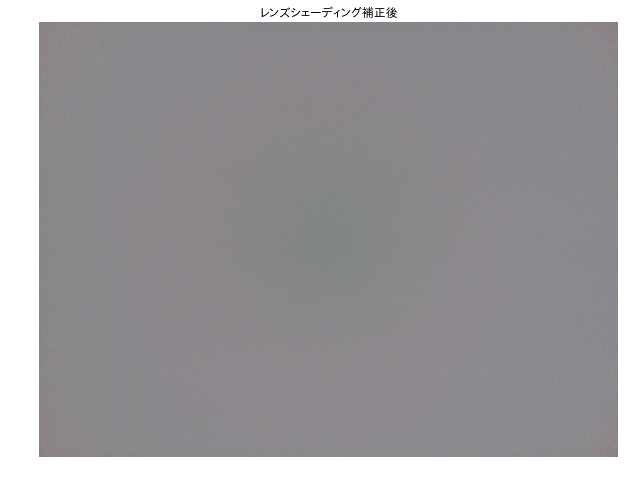

In [16]:
dpc_raw = defect_correction(lsc_raw, 16)
wb_raw = white_balance(dpc_raw, raw.camera_whitebalance, raw.raw_colors)
dms_img = demosaic(wb_raw, raw.raw_colors)
color_matrix = [6022,-2314,394,-936,4728,310,300,-4324,8126]
ccm_img = color_correction_matrix(dms_img, color_matrix)
shading_img = gamma_correction(ccm_img, 2.2)

# 画像表示
plt.figure(figsize=(16, 8))
plt.imshow(shading_img)
plt.axis('off')
plt.title(u"レンズシェーディング補正後")
plt.show()

RGB画像で効果が確認できました。

残っているシェーディング量を測定してみましょう。

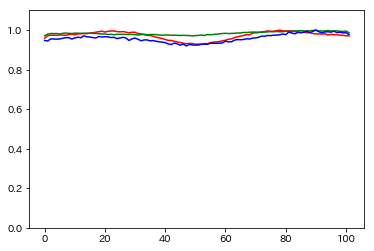

In [17]:
#画素の明るさの横方向の分布の測定。 
center_y, center_x = h // 2, w // 2
shading_after = [[], [], []]
y = center_y - 16
for x in range(0, w - 32, 32):
    xx = x + 16
    shading_after[0].append(shading_img[y:y+32, x:x+32, 0].mean())
    shading_after[1].append(shading_img[y:y+32, x:x+32, 1].mean())
    shading_after[2].append(shading_img[y:y+32, x:x+32, 2].mean())
shading_after = [np.array(a) / max(a) for a in shading_after]

plt.axis(ymin=0, ymax=1.1)
plt.plot(shading_after[0], color='red')
plt.plot(shading_after[1], color='green')
plt.plot(shading_after[2], color='blue')
plt.show()

シェーディングがほぼなくなりフラットになりました。
また、赤色と緑・青色との違いもほぼ消えました。成功のようです。

## 通常画像への適用

それではテスト用の平坦画像(Flat Field)ではなく、実際の画像にレンズシェーディング補正を適用してみましょう。

今回も`chart.jpg`を使います。

In [18]:
# 画像をダウンロードします。
!if [ ! -f chart.jpg ]; then wget https://github.com/moizumi99/camera_raw_processing/raw/master/chart.jpg; fi

# 自分で撮影した画像を使用する場合は以下のコメントを取り除きアップロードします。
# from google.colab import files
# uploaded = files.upload()

# RAWファイルの名前。
# アップロードしたファイルを使う場合はその名前に変更。
raw_file  = "chart.jpg"
raw = rawpy.imread(raw_file)
raw_array = raw.raw_image
h, w = raw.sizes.raw_height, raw.sizes.raw_width
raw_array = raw_array.reshape((h, w));

ではRAW画像データを取り出し、まずはレンズシェーディング補正なしで現像してみます。

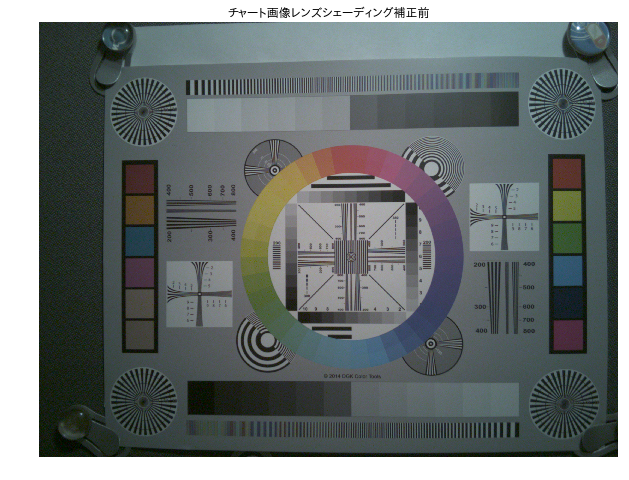

In [19]:
#RAW現像処理
blc_raw = black_level_correction(raw_array, raw.black_level_per_channel, raw.raw_pattern)
dpc_raw = defect_correction(blc_raw, 16)
wb_raw = white_balance(dpc_raw, raw.camera_whitebalance, raw.raw_colors)
dms_img = demosaic(wb_raw, raw.raw_colors)
color_matrix = np.array([6022,-2314,394,-936,4728,310,300,-4324,8126])/4096
ccm_img = color_correction_matrix(dms_img, color_matrix)
ccm_img[ccm_img > 1023] = 1023
no_shading_img = gamma_correction(ccm_img, 2.2)

# 画像表示
plt.figure(figsize=(16, 8))
plt.imshow(no_shading_img)
plt.axis('off')
plt.title(u"チャート画像レンズシェーディング補正前")
plt.show()

レンズシェーディングの影響に気をつけてみると、周辺部が若干暗くなっているのがわかると思います。
また、全体に青みがかっているようです。

それでは次にレンズシェーディング補正を入れて処理してみます。補正パラメータは先程の平坦画像で計算したものを使います。

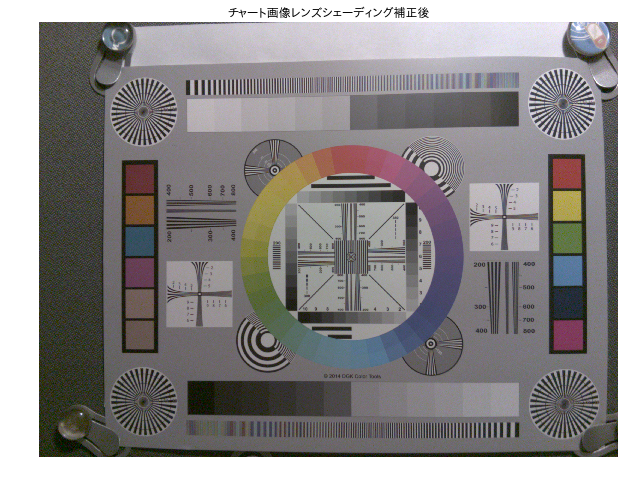

In [20]:
blc_raw = black_level_correction(raw_array, raw.black_level_per_channel, raw.raw_pattern)
#先程計算したゲインマップを使いシェーディング補正。
lsc_raw = blc_raw * gain_map
dpc_raw = defect_correction(lsc_raw, 16)
wb_raw = white_balance(dpc_raw, raw.camera_whitebalance, raw.raw_colors)
dms_img = demosaic(wb_raw, raw.raw_colors)
color_matrix = np.array([6022,-2314,394,-936,4728,310,300,-4324,8126])/4096
ccm_img = color_correction_matrix(dms_img, color_matrix)
ccm_img[ccm_img > 1023] = 1023
shading_img = gamma_correction(ccm_img, 2.2)

# 画像表示
plt.figure(figsize=(16, 8))
plt.imshow(shading_img)
plt.axis('off')
plt.title(u"チャート画像レンズシェーディング補正後")
plt.show()

先程の画像に比べると明るさが均一になり、不自然な青みも消えました。
成功のようです。

## モジュールへの追加

この処理も関数としてモジュールへ追加しておきましょう。

In [42]:
def lens_shading_correction(raw_array, coef):
    """
    レンズシェーディング補正を行う。
    
    Parameters
    ----------
    raw_array: numpy array
        Bayerフォーマット入力RAW画像
    coef: array of size 4x2
        coef[c][1]: 定数項
        coef[c][0]: 傾き
        cはBayer配列内のカラーチャンネル
        c = 0: 左上
        c = 1: 右上
        c = 2: 左下
        c = 3: 右下
    
    Returns
    -------
    lsc_raw: numpy array
        出力RAW画像
    """
    
    # ゲインマップの保存場所。
    gain_map = np.zeros(raw_array.shape)
    # 起点となる画像の中心位置。
    center_y, center_x = h // 2, w // 2
    # 中心からの距離を配列に保存。
    x = np.arange(0, w) - center_x
    y = np.arange(0, h) - center_y
    # numpyのmeshgridは,x, yを並べた配列を生成する。
    # この場合範囲内のi, jに対し、xs[i, j] = x[j]
    # 同様にi, jに対し、ys[i, j] = y[i]
    xs, ys = np.meshgrid(x, y, sparse=True)
    # 各点ごとの中心からの距離を計算
    r2 = ys * ys + xs * xs
    # 中心からの距離に係数をかけて各点のゲインを計算。
    gain_map[::2, ::2] = r2[::2, ::2] * coef[0][0] + coef[0][1]
    gain_map[1::2, ::2] = r2[1::2, ::2] * coef[1][0] + coef[1][1]
    gain_map[::2, 1::2] = r2[::2, 1::2] * coef[2][0] + coef[2][1]
    gain_map[1::2, 1::2] = r2[1::2, 1::2] * coef[3][0] + coef[3][1]
    # 入力画像にゲインをかけ合わせる。
    lsc_array = raw_array * gain_map
    return lsc_array

正常に動作するか確認しておきます。

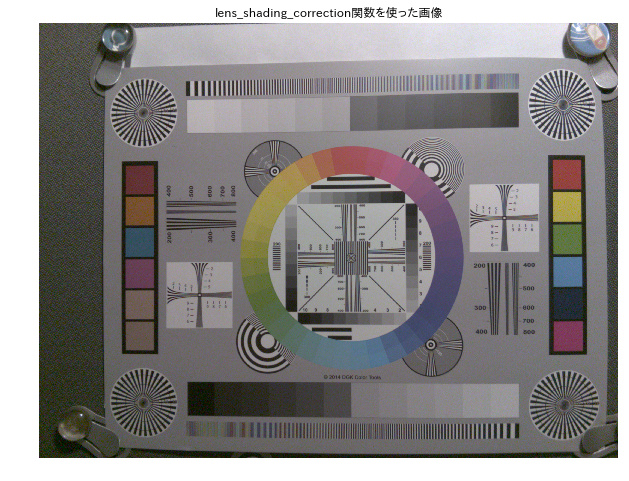

In [44]:
blc_raw = black_level_correction(raw_array, raw.black_level_per_channel, raw.raw_pattern)
lsc_raw = lens_shading_correction(blc_raw, par)
dpc_raw = defect_correction(lsc_raw, 16)
wb_raw = white_balance(dpc_raw, raw.camera_whitebalance, raw.raw_colors)
dms_img = demosaic(wb_raw, raw.raw_colors)
color_matrix = np.array([6022,-2314,394,-936,4728,310,300,-4324,8126])/4096
ccm_img = color_correction_matrix(dms_img, color_matrix)
ccm_img[ccm_img > 1023] = 1023
shading_img = gamma_correction(ccm_img, 2.2)

# 画像表示
plt.figure(figsize=(16, 8))
plt.imshow(shading_img)
plt.axis('off')
plt.title(u"lens_shading_correction関数を使った画像")
plt.show()

正常に処理できているようです。

## まとめ

今回はレンズシェーディング補正（周辺減光補正）をとりあげました。
おそらく、『カメラ』画像処理以外のいわゆる画像処理では取り上げることのない特殊な処理だと思います。

今回行ったのは、半径方向の二次多項式による補正ゲインの近似で、レンズシェーディング補正の中では最も単純なものです。
実際のカメラの中では、より高次の関数による近似や、２次元ルックアップテーブルによる補正などが行われているのが普通です。
また、補正パラメータも、明るさや光源の種類、オートフォーカスの場合はフォーカス位置、などにより調整します。

一見単純そうな見た目や効果と比べて、実際には遥かに複雑で非常に重要な処理です。ある意味カメラの出力画像の画質を決める肝と言ってもよいと思います。

これで第４章は終わりです。次は[第五章 画像をきれいにする処理](https://colab.research.google.com/github/moizumi99/camera_raw_processing/blob/master/camera_raw_chapter_5.ipynb)に入ります。